In [281]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [282]:
test_df = pd.read_csv('./data/test.csv')
train_df = pd.read_csv('./data/train.csv')

In [283]:
print(train_df.info())
print("-----------------------------------")
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
-----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

Check if gender plays a role in survival

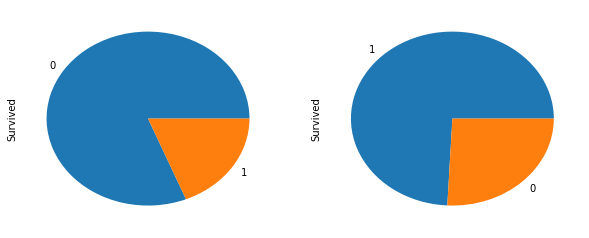

In [284]:
fig = plt.figure(figsize=(10, 4))
fig.add_subplot(121)
train_df.Survived[train_df['Sex'] == 'male'].value_counts().plot(kind='pie')
fig.add_subplot(122)
train_df.Survived[train_df['Sex'] == 'female'].value_counts().plot(kind='pie')

In [285]:
from sklearn.preprocessing import LabelEncoder
train_df['Sex'] = LabelEncoder().fit_transform(train_df['Sex'])
test_df['Sex'] = LabelEncoder().fit_transform(test_df['Sex'])

In [286]:
train_df.Name = train_df.Name.map(lambda name: name.split(',')[1].split('.')[0].strip())
test_df.Name = test_df.Name.map(lambda name: name.split(',')[1].split('.')[0].strip())
titles = train_df.Name.unique()

In [287]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(6), object(4)
memory usage: 83.6+ KB


In [288]:
train_df.Age.fillna(-1, inplace=True)
medians = dict()
for title in titles:
    median = train_df.Age[(train_df.Age != -1) & (train_df.Name == title)].median()
    medians[title] = median;

for index, row in train_df.iterrows():
    if row['Age'] == -1:
        train_df.loc[index, 'Age'] = medians[row['Name']]

test_df.Age.fillna(-1, inplace=True)
for index, row in test_df.iterrows():
    if row['Age'] == -1:
        test_df.loc[index, 'Age'] = medians[row['Name']]

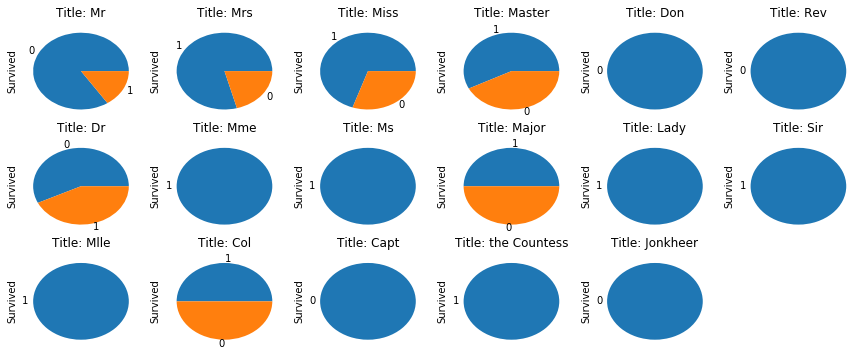

In [289]:
fig = plt.figure(figsize=(15, 6))
i = 1
for title in train_df.Name.unique():
    fig.add_subplot(3, 6, i)
    plt.title('Title: {}'.format(title))
    train_df.Survived[train_df.Name==title].value_counts().plot(kind='pie')
    i+=1

In [290]:
name_replacement = train_df[['Survived', 'Name']].groupby('Name').mean()
name_replacement_mean = train_df.Survived.mean()
for index, row in train_df.iterrows():
    train_df.loc[index, 'Name'] = name_replacement.Survived[row.Name]

for index , row in test_df.iterrows():
    val = 0.0
    try:
        val = name_replacement.Survived[row.Name]
    except KeyError:
        val = name_replacement_mean
    test_df.loc[index, 'Name'] = val

In [291]:
train_df.Fare.fillna(-1, inplace=True)
medians = train_df[['Pclass','Fare']].groupby('Pclass').median()
for index, row in train_df.iterrows():
    if row.Fare == -1:
        train_df.loc[index, 'Fare'] = medians.Fare[row.Pclass]
        
test_df.Fare.fillna(-1, inplace=True)
for index, row in test_df.iterrows():
    if row.Fare == -1:
        test_df.loc[index, 'Fare'] = medians.Fare[row.Pclass]

In [292]:
parch_replacement = train_df[['Survived', 'Parch']].groupby('Parch').mean()
parch_replacement_mean = train_df.Survived.mean()
for index, row in train_df.iterrows():
    train_df.loc[index, 'Parch'] = parch_replacement.Survived[row.Parch]

for index, row in test_df.iterrows():
    val = 0.0
    try:
        val = parch_replacement.Survived[row.Parch]
    except KeyError:
        val = parch_replacement_mean
    test_df.loc[index, 'Parch'] = val

In [293]:
train_df.drop('Ticket', axis = 1, inplace=True)
test_df.drop('Ticket', axis = 1, inplace=True)

In [294]:
embarked_replacement = train_df[['Survived', 'Embarked']].groupby('Embarked').mean()
embarked_replacement_mean = train_df.Survived.mean()
train_df.fillna('S', inplace=True)
for index, row in train_df.iterrows():
    train_df.loc[index, 'Embarked'] = embarked_replacement.Survived[row.Embarked]

for index, row in test_df.iterrows():
    val = 0.0
    try:
        val = embarked_replacement.Survived[row.Embarked]
    except KeyError:
        val = embarked_replacement_mean
    test_df.loc[index, 'Embarked'] = val

In [295]:
train_df.drop(['Cabin', 'PassengerId'], axis =1, inplace=True)
test_df.drop(['Cabin'], axis =1, inplace=True)

In [296]:
train_lebels = train_df.pop('Survived')
test_passengerId = test_df.pop('PassengerId')

In [316]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
# clf = svm.SVC()
clf = RandomForestClassifier(n_estimators=100)
clf.fit(train_df.values, train_lebels.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [317]:
predicted = clf.predict(test_df.values)

In [299]:
#test_passengerId['Survived'] = pd.DataFrame(predicted)

In [318]:
output = pd.DataFrame(test_passengerId.values)
output['Survived'] = predicted

In [319]:
output.columns = ['PassengerId','Survived']
output.to_csv('./data/submit_v4.csv', index=False)